In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import sqlite3
import numpy as np
import pandas as pd
import eofs.standard as eofs
import pylab as plt
import scipy.stats as stats
import scipy.signal as signal
from mpl_toolkits.basemap import Basemap
import tools

In [3]:
plt.style.use("coolbeans")

In [4]:
DB_PATH = "./data/stationdb.sqlite"
ERAI_PATH = "./data/erai.npz"
OISST_PATH = "./data/oisst.npz"
WATER_YEAR = {"low": 1983,
              "high": 2012}
WESTOFLON = -104
EASTOFLON = -125
CAL_YEAR = {"low": WATER_YEAR["low"] - 1,
            "high": WATER_YEAR["high"]}

In [5]:
# Grab data from SQLITE3 DB.
target_stations = [i for i in tools.check_monthly(DB_PATH, CAL_YEAR["low"], CAL_YEAR["high"], WESTOFLON, EASTOFLON)]
conn = sqlite3.connect(DB_PATH)
# sql_query = "SELECT stationid, wy, avg(mean) FROM StationMonthly WHERE wy <= {wy_high} AND wy >= {wy_low} AND stationid IN ({seq}) GROUP BY stationid, wy ORDER BY stationid, wy ASC".format(wy_low = str(WATER_YEAR["low"]), wy_high = str(WATER_YEAR["high"]), seq = ",".join(["?"] * len(target_stations)))
sql_query = "SELECT stationid, year, mean FROM StationWY WHERE year <= {wy_high} AND year >= {wy_low} AND stationid IN ({seq}) GROUP BY stationid, year ORDER BY stationid, year ASC".format(wy_low = str(WATER_YEAR["low"]), wy_high = str(WATER_YEAR["high"]), seq = ",".join(["?"] * len(target_stations)))
raw = pd.read_sql(sql_query, conn, params = target_stations, index_col = ["year", "stationid"])
conn.close()

In [6]:
# Get corresponding latitude and longitude.
conn = sqlite3.connect(DB_PATH)
sql_query = "SELECT stationid, latgage, longage FROM StationInfo WHERE stationid IN ({seq}) ORDER BY stationid ASC".format(seq = ",".join(["?"] * len(target_stations)))
latlon = pd.read_sql(sql_query, conn, params = target_stations)
conn.close()

## Streamflow gage map

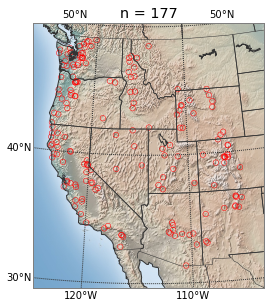

In [7]:
# Plot simple sample map.
out = tools.plot_gagesmap(latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())


## Mapped SSI linear trend

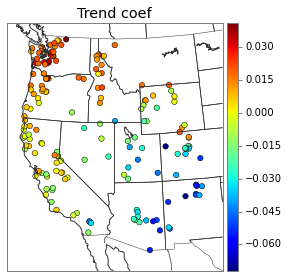

In [8]:
# Parse and shape the data we grabbed. Standardize it. Grad trend coefficients.
parsed = raw.groupby(level = "stationid")["mean"].transform(tools.spigamma)

trend_coefs = parsed.groupby(level = "stationid").apply(tools.trender)
# Detrending. Let's see what happens.
# parsed = parsed.groupby(level = "stationid").transform(signal.detrend)
# parsed = parsed.unstack()

# Map trend coefs.
out = tools.plot_trendmap(trend_coefs, latlon["latgage"].as_matrix(), latlon["longage"].as_matrix())

In [9]:
# Interesting iterations are:
# 1) standardized, correlation or covariance (`center = True` in this case).
# 2) Non-standardized correlation.
examine_modes = 6
solver = eofs.Eof(parsed.unstack().as_matrix(), center = False)
eof = solver.eofsAsCovariance(neofs = examine_modes)
pc = solver.pcs(npcs = examine_modes, pcscaling = 1)
frac_var = solver.varianceFraction(examine_modes)

## Basic North Test scree plot

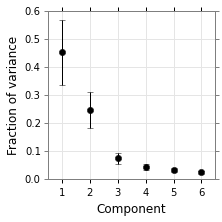

In [10]:
# Basic North Test plot

out = tools.plot_northtest(solver, nmodes = examine_modes)

## PC time series from leading components

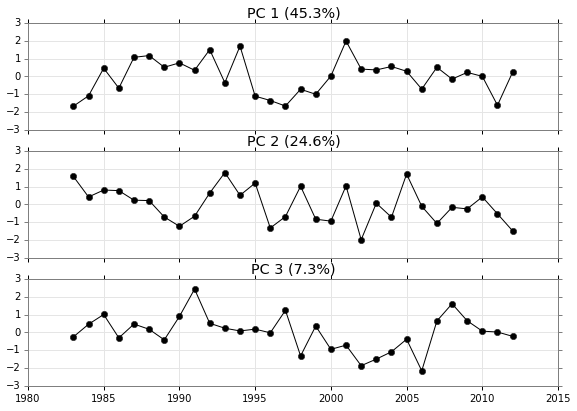

In [11]:
# Plot 6 leading PCs.
retain_modes = 3
wy_range = np.arange(WATER_YEAR["low"], WATER_YEAR["high"] + 1)
out = tools.plot_pc(solver, yr = wy_range, nmodes = retain_modes)

## Leading EOFs mapped as covariance

/usr/local/lib/python3.4/dist-packages/matplotlib/tri/triangulation.py:110: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  self._neighbors)


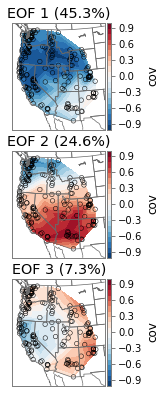

In [12]:
# Plot 6 leading EOFs.

out = tools.plot_eof(solver, 
                     lat = latlon["latgage"].as_matrix(),
                     lon = latlon["longage"].as_matrix(), 
                     nmodes = retain_modes)

## Leading two modes as vectors

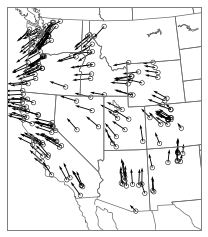

In [13]:
# Linear regression of the first two leading PCs onto the gage time series to get regression coefficients.
rcoef1 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 0], x)[0])
rcoef2 = parsed.groupby(level = "stationid").aggregate(lambda x: stats.linregress(pc[:, 1], x)[0])

out = tools.plot_vectormap(coef1 = rcoef1, coef2 = rcoef2,
                           lat = latlon["latgage"].as_matrix(),
                           lon = latlon["longage"].as_matrix())

# Point correlation maps

## Northern hemisphere NDJ 500 mb geopotential height

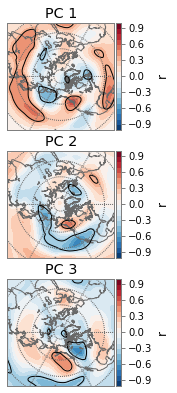

In [14]:
# Plot NDJ 500 mb point correlations.

erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= WATER_YEAR["low"]) & (erai["time"] <= WATER_YEAR["high"])
hgts = erai["data"][0, 1, msk_time]
hgts = hgts - np.mean(hgts, 0)
out = tools.plot_pearson(solver, hgts, 
                         lat = erai["lat"], lon = erai["lon"], 
                         nmodes = retain_modes)

## Detrended NDJ global SST

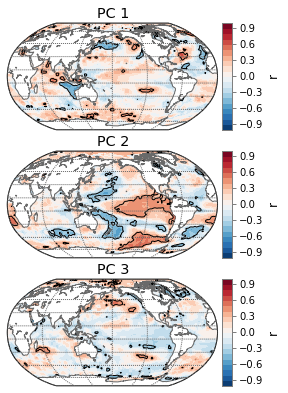

In [15]:
# Correlate PCs with OI SST data (NDJ mean) detrended anomalies.

oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= WATER_YEAR["low"]) & (oisst["time"] <= WATER_YEAR["high"])
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")
sst = sst - np.mean(sst, 0)
out = tools.plot_pearson(solver, sst, 
                         lat = oisst["lat"], lon = oisst["lon"], 
                         nmodes = retain_modes, 
                         msk = oisst["landmask"], world_map = True)

# Composite maps

## Northern hemisphere NDJ 500 mb geopotential height

In [16]:
# Composite map of NDJ mean 500 mb height anomalies.
erai = np.load(ERAI_PATH)
msk_time = (erai["time"] >= WATER_YEAR["low"]) & (erai["time"] <= WATER_YEAR["high"])
hgts = erai["data"][0, 1, msk_time]


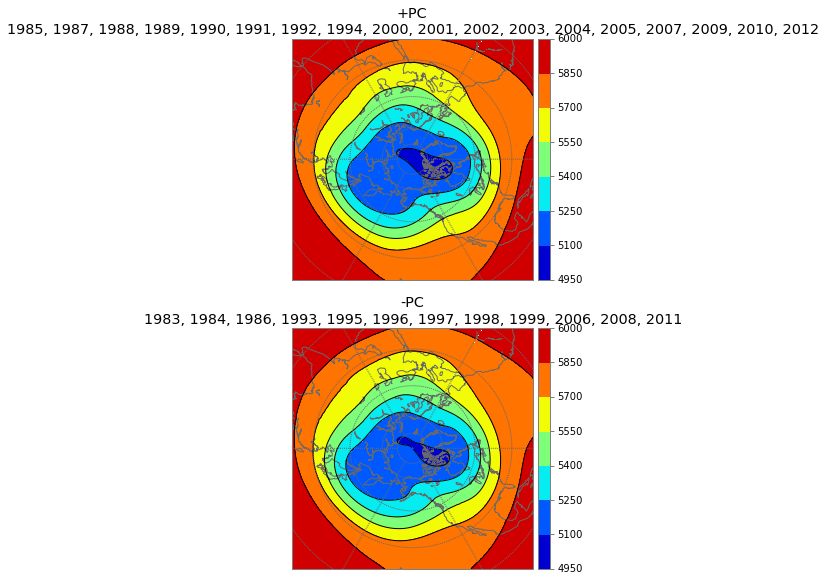

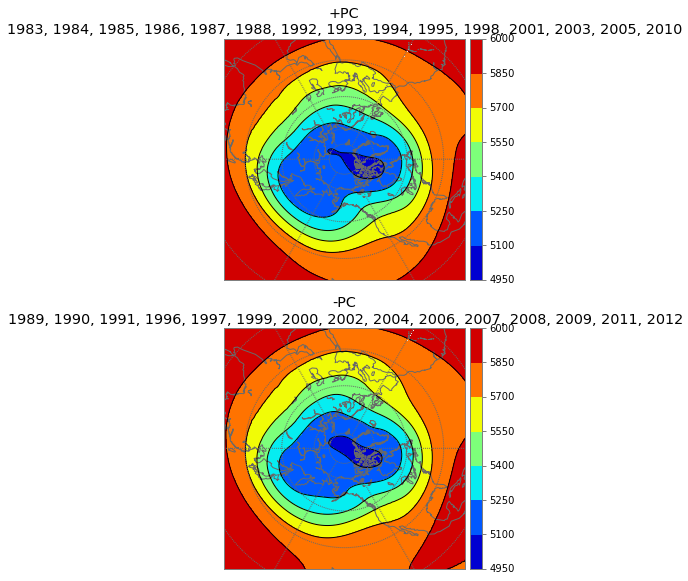

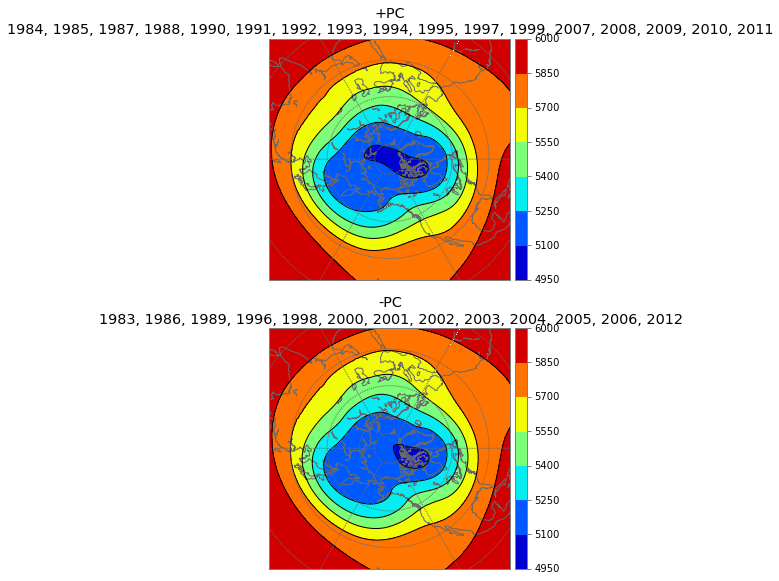

In [18]:

for i in range(retain_modes):
    out = tools.plot_many_hgt_composites(pc[:, i], wy_range, 
                                         field = hgts, 
                                         lat = erai["lat"], lon = erai["lon"])

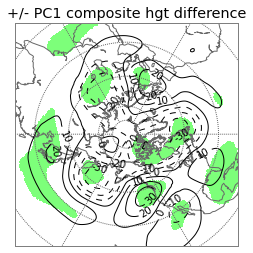

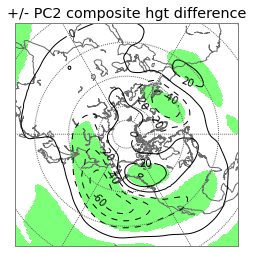

In [19]:
# Welch's t-test comparing upper and lower quartiles.
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.5, 1], labels = ["low", "high"])
#     quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    t, p = stats.ttest_ind(hgts[(quarts == "high")], hgts[(quarts == "low")], equal_var = False)
    d = np.mean(hgts[(quarts == "high")], 0) - np.mean(hgts[(quarts == "low")], 0)
    plt.figure(figsize = (5, 4))
    m = Basemap(projection = 'npstere', boundinglat = 20, lon_0 = 210, resolution='c')
    c = np.ma.masked_array(p, ~(p <= 0.1))
    x, y = m(erai["lon"], erai["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    ct = m.contour(x, y, d, colors = "k")
    plt.clabel(ct, fontsize = 10, inline = 1, fmt = "%1.0f")
    m.contourf(x, y, c, 0)
    plt.title("+/- PC"+ str(i + 1) + " composite hgt difference")
    plt.show()

## Detrended NDJ global SST

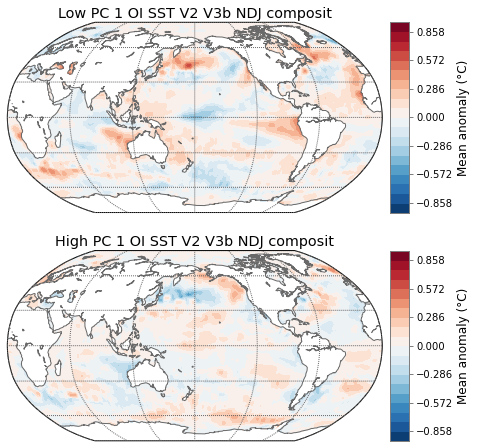

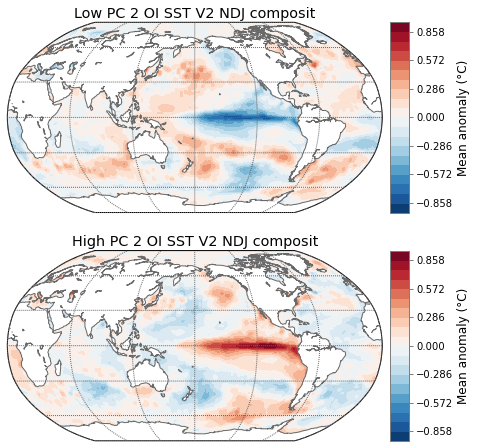

PC1 low+high:
[1983 1984 1986 1995 1996 1997 1998 1999 2006 2011]
[1985 1987 1988 1989 1990 1992 1994 2001 2004 2007]
PC2 low+high:
[1989 1990 1996 1997 1999 2000 2002 2004 2007 2012]
[1983 1985 1986 1992 1993 1994 1995 1998 2001 2005]


In [20]:
# Composite map of NDJ detrended sea surface temperature anomalies.
oisst = np.load(OISST_PATH)
msk_time = (oisst["time"] >= WATER_YEAR["low"]) & (oisst["time"] <= WATER_YEAR["high"])
sst = oisst["data"][0, msk_time][:]
sst = signal.detrend(sst, axis = 0, type = "linear")

# First dim is PC, second is 0 -> low, 1 -> high:
composit_anoms = np.zeros((2, 2, sst.shape[1], sst.shape[2]))
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    composit_anoms[i, 0] = np.mean(sst[(quarts == "low")], 0) - np.mean(sst, 0)
    composit_anoms[i, 1] = np.mean(sst[(quarts == "high")], 0) - np.mean(sst, 0)

wings = np.max([np.absolute(composit_anoms.min()), np.absolute(composit_anoms.max())])
divs = np.linspace(-wings, wings, 21)
fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[0, i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("Mean anomaly (°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 1" + " OI SST V2 V3b NDJ composit")
plt.show()

fig, axes = plt.subplots(figsize = (8, 7.5), nrows = 2, ncols = 1)
for i in range(2):
    c = np.ma.masked_array(composit_anoms[1, i], oisst["landmask"])
    m = Basemap(ax = axes.flat[i], projection = "robin", lon_0 = 180, resolution = "c")
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90.,120.,30.), color = "#696969")
    m.drawmeridians(np.arange(0.,360.,60.), color = "#696969")
    pcol = m.contourf(x, y, c, divs, cmap = plt.cm.RdBu_r)
    cb = m.colorbar(pcol)
    cb.set_label("Mean anomaly (°C)")
    axes.flat[i].set_title(("Low", "High")[i]+" PC 2" + " OI SST V2 NDJ composit")
plt.show()

quarts = pd.qcut(pc[:, 0], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
print("PC1 low+high:")
print(wy_range[quarts == "low"])
print(wy_range[quarts == "high"])
quarts = pd.qcut(pc[:, 1], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
print("PC2 low+high:")
print(wy_range[quarts == "low"])
print(wy_range[quarts == "high"])

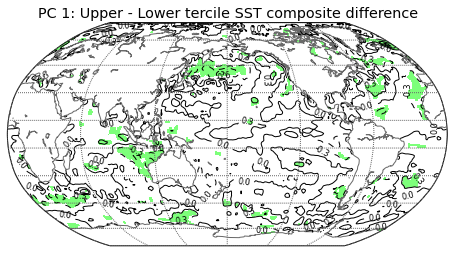

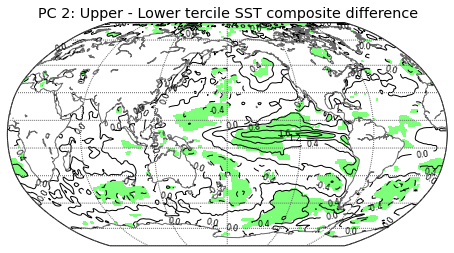

In [21]:
# Welch's t-test comparing upper and lower quartiles.
for i in range(2):
    quarts = pd.qcut(pc[:, i], [0, 0.33, 0.66, 1], labels = ["low", "mid", "high"])
    t, p = stats.ttest_ind(sst[(quarts == "high")], sst[(quarts == "low")], equal_var = False)
    d = np.mean(sst[(quarts == "high")], 0) - np.mean(sst[(quarts == "low")], 0)
    d = np.ma.masked_array(d, oisst["landmask"])
    p = np.ma.masked_array(p, oisst["landmask"])
    plt.figure(figsize = (8, 4))
    m = Basemap(projection = "robin", lon_0 = 180, resolution = "c")
    c = np.ma.masked_array(p, ~(p <= 0.1))
    x, y = m(oisst["lon"], oisst["lat"])
    m.drawcoastlines(color = "#696969")
    m.drawparallels(np.arange(-90, 110, 20), color = "#696969")
    m.drawmeridians(np.arange(0, 360, 60), color = "#696969")
    ct = m.contour(x, y, d, colors = "k")
    plt.clabel(ct, fontsize=8, inline=1, fmt = "%1.1f")
    m.contourf(x, y, c, 0)
    plt.title("PC " + str(i + 1) + ": Upper - Lower tercile SST composite difference")
    plt.show()